**Introduction**


This analysis aims to identify the key factors influencing real estate prices in Warsaw.

We start with a broad **correlation analysis** to determine which features have strong relationships with property prices.

Next, we apply **Lasso regression**, a **linear regression** model that incorporates L1 regularization, to quantify the monetary impact (in PLN) of individual features on property prices.

Finally, we extend our analysis by using **XGBoost and SHAP values** to capture and interpret **non-linear relationships** between features and prices, providing a more nuanced understanding of the factors driving real estate prices in Warsaw(also in PLN).

By the end of this analysis, we will have both a conceptual and statistical understanding of the variables that influence property prices in the city.

# **0.Binning numerical values**
For our linear regression model, we need to bin continuous data into categorical ranges, which will allow us to better understand how specific distance categories affect price. For example, instead of using one continuous column for centreDistance, we will create categorical bins (e.g., 0-1 km, 1-2 km) and apply one-hot encoding to these bins. This will help us observe how different distance ranges impact the price more clearly.

In [1]:
import pandas as pd

preprocessed_data = pd.read_csv('/content/drive/MyDrive/Warsaw_Real_Estate/PREPROCESSED_DATA/Preprocesed_data.csv')

In [2]:
data=preprocessed_data.copy()

In [3]:
data.columns

Index(['squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear',
       'centreDistance', 'schoolDistance', 'clinicDistance',
       'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance',
       'collegeDistance', 'pharmacyDistance', 'hasParkingSpace', 'hasBalcony',
       'hasElevator', 'hasSecurity', 'hasStorageRoom', 'year', 'month_01',
       'month_02', 'month_03', 'month_04', 'month_05', 'month_06', 'month_07',
       'month_08', 'month_09', 'month_10', 'month_11', 'month_12',
       'Train_distance', 'Metro_distance', 'Tram_distance', 'Bus_distance',
       'Mall_distance', 'SquareMeterPrice', 'type_apartmentBuilding',
       'type_blockOfFlats', 'type_tenement', 'condition_low',
       'condition_normal', 'condition_premium', 'ownership_condominium',
       'ownership_cooperative', 'buildingMaterial_UNKNOWN',
       'buildingMaterial_brick', 'buildingMaterial_concreteSlab',
       'district_Bemowo', 'district_Bialoleka', 'district_Bielany',
       'district_Moko

**Bin sizes**

-squareMeters -5 meters

-buildYear    -5years

-rooms        -1room

-floor        -1 floor

-floorCount   -1 floor


In [4]:
print(f"centreDistance:  {data['centreDistance'].max()/10:.3} km bin")
print(f"schoolDistance:  {data['schoolDistance'].max()/10:.3} km bin")
print(f"clinicDistance:  {data['clinicDistance'].max()/10:.3} km bin")
print(f"kindergartenDistance:  {data['kindergartenDistance'].max()/10:.3} km bin")
print(f"collegeDistance:  {data['collegeDistance'].max()/10:.3} km bin")
print(f"pharmacyDistance:  {data['pharmacyDistance'].max()/10:.3} km bin")
print(f"postOfficeDistance:  {data['postOfficeDistance'].max()/10:.3} km bin")
print(f"restaurantDistance:  {data['restaurantDistance'].max()/10:.3} km bin")



print(f"Tram _distance:  {data['Tram_distance'].max()/10:.3} km bin")
print(f"Metro _distance:  {data['Metro_distance'].max()/10:.3} km bin")
print(f"Train _distance:  {data['Train_distance'].max()/10:.3} km bin")
print(f"Bus _distance:  {data['Bus_distance'].max()/10:.3} km bin")

centreDistance:  1.46 km bin
schoolDistance:  0.248 km bin
clinicDistance:  0.481 km bin
kindergartenDistance:  0.224 km bin
collegeDistance:  0.5 km bin
pharmacyDistance:  0.318 km bin
postOfficeDistance:  0.338 km bin
restaurantDistance:  0.202 km bin
Tram _distance:  1.0 km bin
Metro _distance:  1.09 km bin
Train _distance:  0.764 km bin
Bus _distance:  0.136 km bin


BIN

In [5]:

columns_to_fix = ['squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear']

for col in columns_to_fix:
    if data[col].dtype == 'object':
        data[col] = data[col].str.replace(',', '.')
    data[col] = data[col].astype(float)

# Every bin of distance contains 10% of range
distance_bin_sizes = {
    'centreDistance': 1.65,
    'schoolDistance': 0.237,
    'clinicDistance': 0.481,
    'kindergartenDistance': 0.2,
    'collegeDistance': 0.499,
    'pharmacyDistance': 0.22,
    'postOfficeDistance': 0.338,
    'restaurantDistance': 0.202,
    'Tram_distance': 1.05,
    'Metro_distance': 1.41,
    'Train_distance': 0.965,
    'Bus_distance': 0.089
}

other_bin_sizes = {
    'squareMeters': 5,   # 5 meters per bin
    'rooms': 1,          # 1 room per bin
    'floor': 1,          # 1 floor per bin
    'floorCount': 1,     # 1 floor count per bin
    'buildYear': 5       # 5 years per bin
}


for feature, bin_size in distance_bin_sizes.items():
    max_value = data[feature].max()
    bins = [i * bin_size for i in range(11)]  # Creating 10 bins


    labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f} km' for i in range(len(bins) - 1)]


    data[f'{feature}_binned'] = pd.cut(data[feature], bins=bins, labels=labels)


    data = pd.get_dummies(data, columns=[f'{feature}_binned'], drop_first=False)

# Apply binning for other features (squareMeters, rooms, etc.)
for feature, bin_size in other_bin_sizes.items():
    max_value = data[feature].max()
    min_value = data[feature].min()
    bins = list(range(int(min_value), int(max_value) + bin_size, bin_size))

    labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins) - 1)]

    data[f'{feature}_binned'] = pd.cut(data[feature], bins=bins, labels=labels)

    data = pd.get_dummies(data, columns=[f'{feature}_binned'], drop_first=False)


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(data.iloc[0])


squareMeters                                        64.9
rooms                                                3.0
floor                                                3.0
floorCount                                          10.0
buildYear                                         1979.0
centreDistance                                      8.41
schoolDistance                                     0.301
clinicDistance                                     0.264
postOfficeDistance                                 0.259
kindergartenDistance                               0.249
restaurantDistance                                 0.157
collegeDistance                                    1.521
pharmacyDistance                                   0.242
hasParkingSpace                                    False
hasBalcony                                          True
hasElevator                                        False
hasSecurity                                        False
hasStorageRoom                 

All looks good, now we can delete columns we don't need

In [7]:
data.drop(['centreDistance', 'schoolDistance', 'clinicDistance', 'kindergartenDistance',
                    'collegeDistance', 'pharmacyDistance', 'postOfficeDistance', 'restaurantDistance',
                    'Tram_distance', 'Metro_distance', 'Train_distance', 'Bus_distance'],axis=1,inplace=True)

In [8]:
data.drop(['floor','rooms','floorCount','buildYear'],axis=1,inplace=True)

In [9]:
data_binned=data.copy()

# **1. Correlation Analysis**



We begin by analyzing the correlation between various features (e.g., size, location, proximity to amenities) and the price per square meter of properties.

 The correlation coefficient ranges **between -1 and 1**, where values **closer to 1 indicate a strong positive correlation**, and values c**loser to -1 indicate a strong negative correlation**.


**Value>0**  Increase price

**Value<0**  Decrease price

In [10]:
correlation_matrix_binned = data_binned.corr()
correlation_output_binned = correlation_matrix_binned['SquareMeterPrice'].sort_values(ascending=False)
print(correlation_output_binned.head(10))


SquareMeterPrice                          1.000000
district_Srodmiescie                      0.331991
buildingMaterial_brick                    0.277673
restaurantDistance_binned_0.00-0.20 km    0.271042
centreDistance_binned_0.00-1.65 km        0.263143
centreDistance_binned_1.65-3.30 km        0.247652
clinicDistance_binned_0.00-0.48 km        0.243670
type_tenement                             0.232806
Metro_distance_binned_0.00-1.41 km        0.226627
year                                      0.222918
Name: SquareMeterPrice, dtype: float64


Now we can plot the results to have all informations clearly presented.

<Figure size 1800x5500 with 0 Axes>

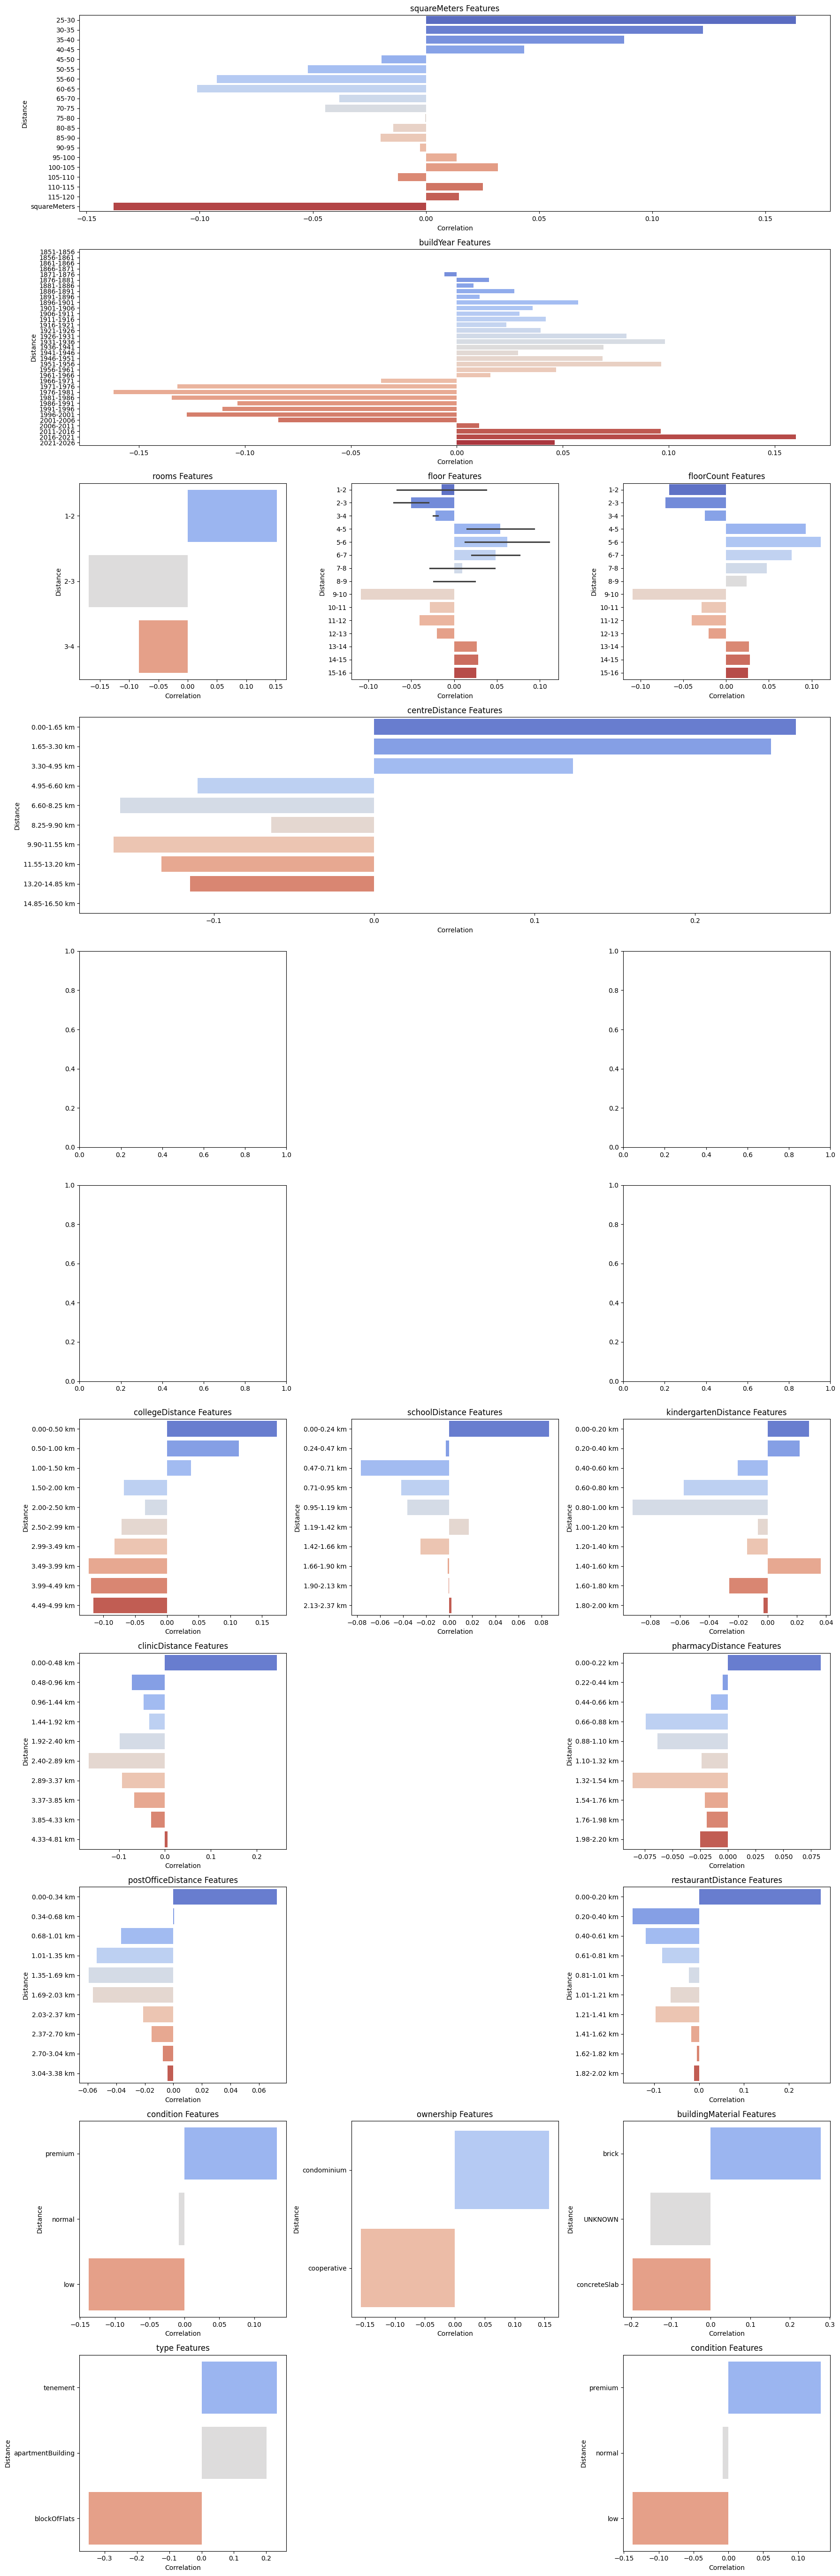

In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

def extract_numeric_range(feature):
    match = re.search(r'(\d+(\.\d+)?)\-(\d+(\.\d+)?)', feature)
    if match:
        return (float(match.group(1)), float(match.group(3)))
    return (float('inf'), float('inf'))

def clean_feature_label(feature):
    return feature.split('_')[-1]

def plot_by_category(correlation_output, category, ax):
    category_corr = correlation_output[correlation_output.index.str.contains(category)]
    if category_corr.empty:
        return

    category_corr_df = category_corr.reset_index()
    category_corr_df.columns = ['Feature', 'Correlation']

    category_corr_df['CleanedFeature'] = category_corr_df['Feature'].apply(clean_feature_label)
    category_corr_df['NumericRange'] = category_corr_df['Feature'].apply(extract_numeric_range)

    category_corr_sorted = category_corr_df.sort_values(by='NumericRange', ascending=True)

    sns.barplot(x='Correlation', y='CleanedFeature', data=category_corr_sorted, palette='coolwarm', ax=ax)
    ax.set_title(f'{category} Features')
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Distance')

fig = plt.figure(figsize=(18, 55))

gs = fig.add_gridspec(11, 3)

def plot_by_category(correlation_output, category, ax):
    category_corr = correlation_output[correlation_output.index.str.contains(category)]
    if category_corr.empty:
        return

    category_corr_df = category_corr.reset_index()
    category_corr_df.columns = ['Feature', 'Correlation']

    category_corr_df['CleanedFeature'] = category_corr_df['Feature'].apply(clean_feature_label)
    category_corr_df['NumericRange'] = category_corr_df['Feature'].apply(extract_numeric_range)

    category_corr_sorted = category_corr_df.sort_values(by='NumericRange', ascending=True)

    sns.barplot(x='Correlation', y='CleanedFeature', data=category_corr_sorted, palette='coolwarm', ax=ax)
    ax.set_title(f'{category} Features')
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Distance')

fig = plt.figure(figsize=(18, 55))
gs = fig.add_gridspec(11, 3)

axes = [
    fig.add_subplot(gs[0, 0:3]),  # Squaremeters
    fig.add_subplot(gs[1, 0:3]),  # Buildyear
    fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2]),  # Rooms, floor, floor count
    fig.add_subplot(gs[3, 0:3]),  # Centredistance
    fig.add_subplot(gs[4, 0]), fig.add_subplot(gs[4, 2]),  # Metro, tram
    fig.add_subplot(gs[5, 0]), fig.add_subplot(gs[5, 2]),  # Train, bus
    fig.add_subplot(gs[6, 0]), fig.add_subplot(gs[6, 1]), fig.add_subplot(gs[6, 2]),  # College, school, kindergarten
    fig.add_subplot(gs[7, 0]), fig.add_subplot(gs[7, 2]),  # Clinic, pharmacy
    fig.add_subplot(gs[8, 0]), fig.add_subplot(gs[8, 2]),  # Post, restaurant
    fig.add_subplot(gs[9, 0]), fig.add_subplot(gs[9, 1]), fig.add_subplot(gs[9, 2]),  # Condition, ownership, material
    fig.add_subplot(gs[10, 0]), fig.add_subplot(gs[10, 2])  # Type, condition
]

categories = ['squareMeters', 'buildYear', 'rooms', 'floor', 'floorCount',
              'centreDistance', 'MetroStop', 'TramStop', 'TrainStop', 'BusStop',
              'collegeDistance', 'schoolDistance', 'kindergartenDistance',
              'clinicDistance', 'pharmacyDistance', 'postOfficeDistance', 'restaurantDistance',
              'condition', 'ownership', 'buildingMaterial', 'type', 'condition']

for category, ax in zip(categories, axes):
    plot_by_category(correlation_output_binned, category, ax)

plt.tight_layout()
plt.show()


As we can see, nearly all of our assumptions from the Power BI analysis have been confirmed by the deeper insights gained through this more detailed data exploration.

One new finding that became clearer with this more in-depth analysis is the pricing of tenement buildings. We have only a couple data records with old tenements which is not enough to make some big assumptions but it is still very interesting that these properties are significantly more expensive than initially revealed in our earlier analysis. The primary factor driving their price remains proximity to the city center. These tenements, many of which were built nearly a century ago, are located close to the city center because, at the time of their construction, Warsaw was a smaller city, making central locations easier to develop.



But our old findings stays the same,


***Key Insights:***


*   **Most Expensive Apartments**: The priciest properties are typically smaller apartments located near the city center. These apartments benefit from proximity to key amenities such as metro stations, schools, and pharmacies, which are all easily accessible. The buildings are often modern apartment complexes constructed from durable materials like brick, which adds further value.
*   **Cheapest Apartments**: The least expensive flats tend to be medium-sized and situated farther from the city center, where the price per square meter is considerably lower. These properties are usually found in large Soviet-era blocks, constructed with cheaper prefabricated concrete slabs. Due to their distance from central Warsaw, they tend to have less immediate access to essential services and public transportation, which further drives down their prices.


# 2. Lasso Regression Analysis

After identifying key correlations, we now perform a more rigorous Lasso regression to quantify the impact of each feature on price. Lasso regression not only helps us identify the most significant features, but also provides coefficients that will help us estimate how much each feature increases or decreases the price.


Calculating precise relationships between various factors and property prices is a complex task that typically requires a large and robust dataset. While the Power BI report provided us with broad trends and a general understanding of how different features may relate to prices, and the correlation analysis highlighted relationships between variables, this new analysis will provide us with concrete values in zlotys (PLN). This will give us a much more accurate and reliable point of reference compared to relying solely on broad trends and correlations.

**Remember**

**These are just estimates, as there is no universal pricing method for features. The value of each element can differ significantly depending on the specific case**




In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd

y = data_binned['SquareMeterPrice']
X = data_binned.drop(columns=['SquareMeterPrice','squareMeters'])

param_grid = {
    'lassocv__alphas': [[0.001, 0.01]],
    'lassocv__max_iter': [1000, 5000],
}

lasso_cv_pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5))

grid_search = GridSearchCV(lasso_cv_pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_

lasso_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient (Zlotys per unit)': best_model.named_steps['lassocv'].coef_
})

significant_features = lasso_coefficients[lasso_coefficients['Coefficient (Zlotys per unit)'] != 0]



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86731457962.20206, tolerance: 57831892.99459285
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101187630866.17236, tolerance: 57831892.99459285
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87274857712.1927, tolerance: 5477220

In [14]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

if 'squareMeters' in X.columns:
    X = X.drop(columns=['squareMeters'])

y_pred = best_model.predict(X)

r2 = r2_score(y, y_pred)

mse = mean_squared_error(y, y_pred)

mae = mean_absolute_error(y, y_pred)

print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


R-squared (R²): 0.6415656923297415
Mean Squared Error (MSE): 5428911.665384685
Mean Absolute Error (MAE): 1781.3310728967733


The Mean Absolute Error is significantly high, which likely indicates that linear models may not perform well on our data. As a result, we must acknowledge that while the plots may not be highly accurate, they can still reveal underlying patterns.

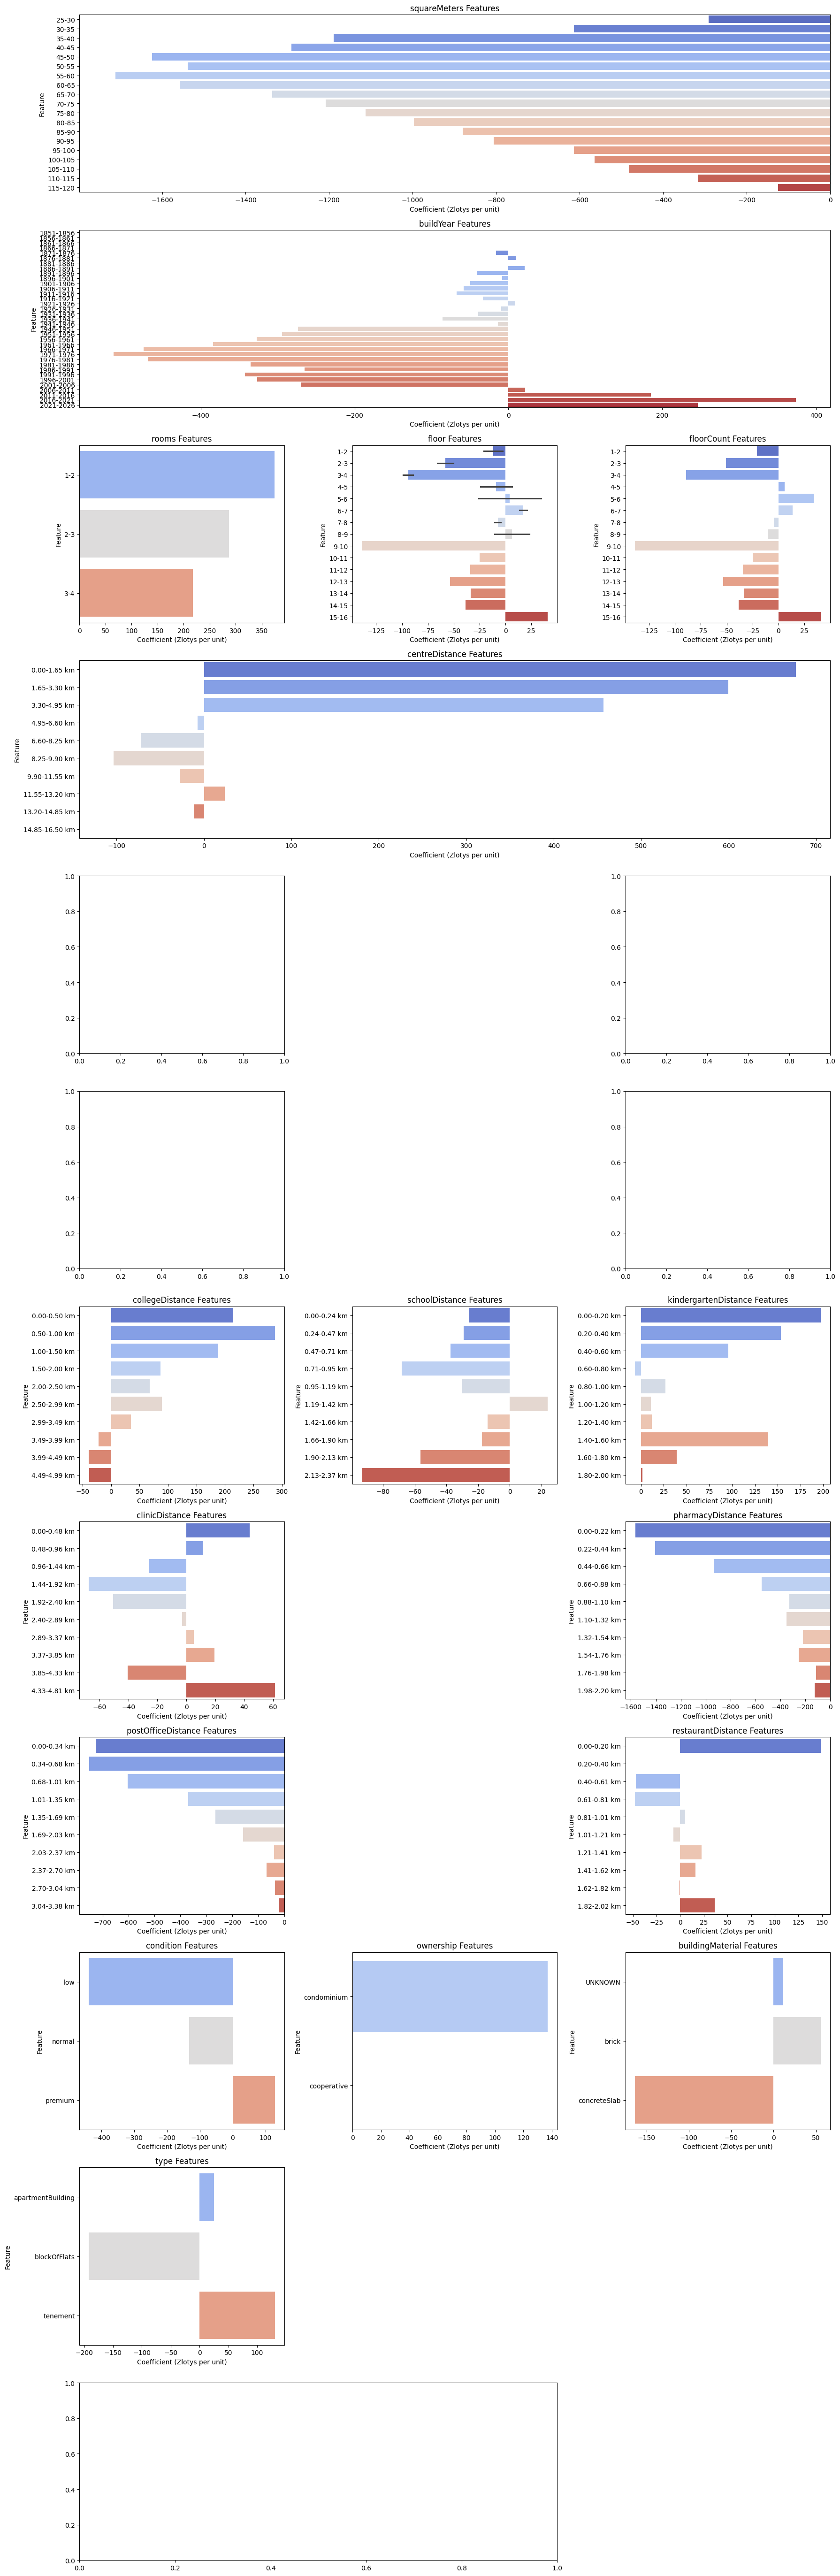

In [15]:

def plot_lasso_by_category(significant_features, category, ax):
    category_coeff = significant_features[significant_features['Feature'].str.contains(category)]
    if category_coeff.empty:
        return

    category_coeff_df = category_coeff.reset_index(drop=True)

    category_coeff_df['CleanedFeature'] = category_coeff_df['Feature'].apply(clean_feature_label)
    category_coeff_df['NumericRange'] = category_coeff_df['Feature'].apply(extract_numeric_range)

    category_coeff_sorted = category_coeff_df.sort_values(by='NumericRange', ascending=True)

    sns.barplot(x='Coefficient (Zlotys per unit)', y='CleanedFeature', data=category_coeff_sorted, palette='coolwarm', ax=ax)
    ax.set_title(f'{category} Features')
    ax.set_xlabel('Coefficient (Zlotys per unit)')
    ax.set_ylabel('Feature')

import matplotlib.pyplot as plt

categories = ['squareMeters', 'buildYear', 'rooms', 'floor', 'floorCount',
              'centreDistance', 'MetroStop', 'TramStop', 'TrainStop', 'BusStop',
              'collegeDistance', 'schoolDistance', 'kindergartenDistance',
              'clinicDistance', 'pharmacyDistance', 'postOfficeDistance',
              'restaurantDistance', 'condition', 'ownership',
              'buildingMaterial', 'type', 'dzielnica']

fig = plt.figure(figsize=(18, 55))
gs = fig.add_gridspec(12, 3)

axes = [
    fig.add_subplot(gs[0, 0:3]),  # Squaremeters
    fig.add_subplot(gs[1, 0:3]),  # Buildyear
    fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2]),  # Rooms, floor, floor count
    fig.add_subplot(gs[3, 0:3]),  # Centredistance
    fig.add_subplot(gs[4, 0]), fig.add_subplot(gs[4, 2]),  # Metro, tram
    fig.add_subplot(gs[5, 0]), fig.add_subplot(gs[5, 2]),  # Train, bus
    fig.add_subplot(gs[6, 0]), fig.add_subplot(gs[6, 1]), fig.add_subplot(gs[6, 2]),  # College, school, kindergarten
    fig.add_subplot(gs[7, 0]), fig.add_subplot(gs[7, 2]),  # Clinic, pharmacy
    fig.add_subplot(gs[8, 0]), fig.add_subplot(gs[8, 2]),  # Post, restaurant
    fig.add_subplot(gs[9, 0]), fig.add_subplot(gs[9, 1]), fig.add_subplot(gs[9, 2]),  # Condition, ownership, material
    fig.add_subplot(gs[10, 0]),  # Type
    fig.add_subplot(gs[11, 0:2])  # Dzielnica
]

for category, ax in zip(categories, axes):
    plot_lasso_by_category(lasso_coefficients, category, ax)

plt.tight_layout()
plt.show()


**Interpreting the Lasso Regression Plots**

These plots provide insight into how various property features influence their price.  Each bar in the plot represents the magnitude by which the property price changes based on the presence or value of a specific feature. If there is no bar, it means algorithm says that magnitude of this specific label is not significant enough to be shown.


*   Positive Values: Indicate features that increase the property price.
*   Negative Values: Indicate features that decrease the property price.


**Example Interpretation:**

Consider two identical apartments with the only difference being their condition:

A flat in low condition might reduce the price by approximately 400 zlotys.
A flat in premium condition might increase the price by around 250 zlotys.
As a result, the premium-condition apartment would be 650 zlotys more expensive than the low-condition one.

**Important Notes:**

These values represent average impacts, so individual cases may vary. Therefore, the calculations may not be as accurate for properties at the extreme ends of the price spectrum (i.e., very cheap or very expensive properties).









# **3.SHAP values from XGBoost**

Third and last analysis will be identifiing, impact on price using SHAP(SHapley Additive exPlanations) values from non-linear XGBoost model.

Unlike linear models, which assume a straightforward relationship between features and the target variable, XGBoost is a powerful gradient boosting algorithm that captures non-linear relationships in the data. By applying SHAP values, we can break down the estimation of this complex model and understand the contribution of each feature to the final property price.




In [16]:
pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.3 MB/s eta 0:00:00


In [18]:
import xgboost as xgb
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

X = data_binned.drop('SquareMeterPrice', axis=1)
y = data_binned['SquareMeterPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse}")
print(f"Our model absolute error is  {np.sqrt(rmse)}, which is about {(np.sqrt(rmse)/18500)*100:.3} percent of average")

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

Test RMSE: 1992.6701205457398
Our model absolute error is  44.63933378250329, which is about 0.241 percent of average


This suggests that nonlinear, tree-based models such as XGBoost may be the most suitable choice for our data

In [19]:
import re

def find_columns_by_keyword(df, keyword):
    return [col for col in df.columns if keyword in col]

def extract_numeric_range(feature_name):
    match = re.search(r'(\d+(\.\d+)?)\-(\d+(\.\d+)?)', feature_name)
    if match:
        return float(match.group(1)), float(match.group(3))
    return float('inf'), float('inf')

def sort_by_numeric_range(columns):
    return sorted(columns, key=lambda x: (extract_numeric_range(x)[0], extract_numeric_range(x)[1]))


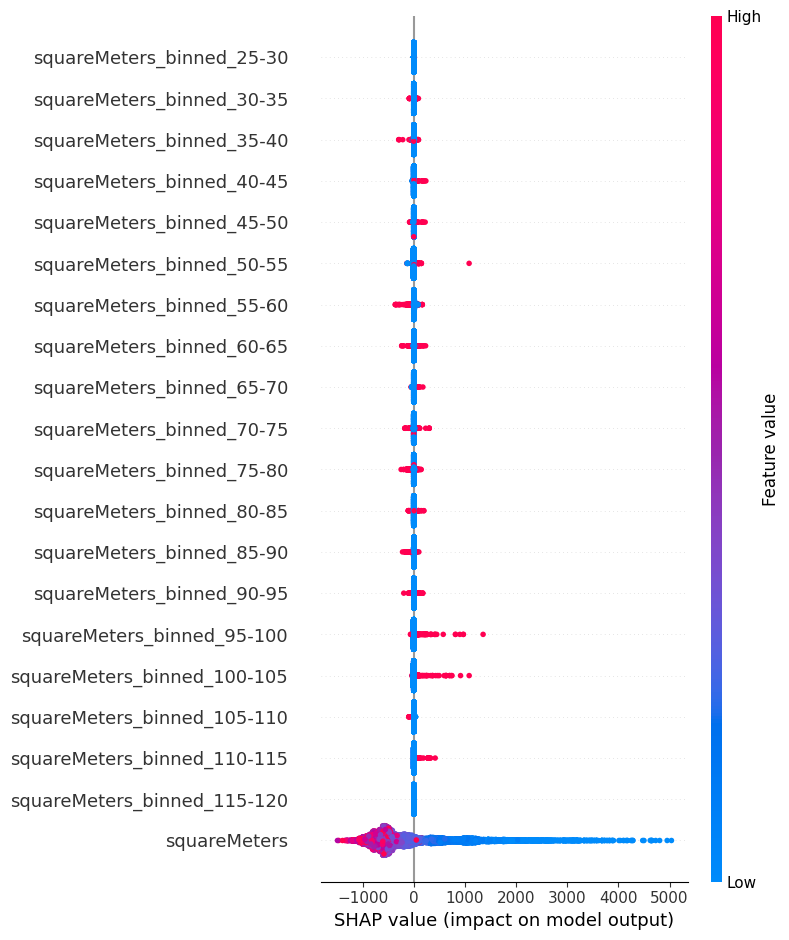

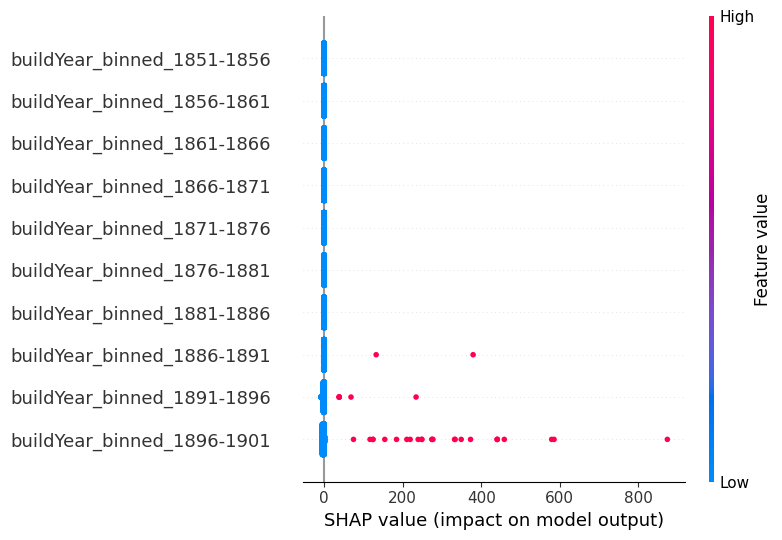

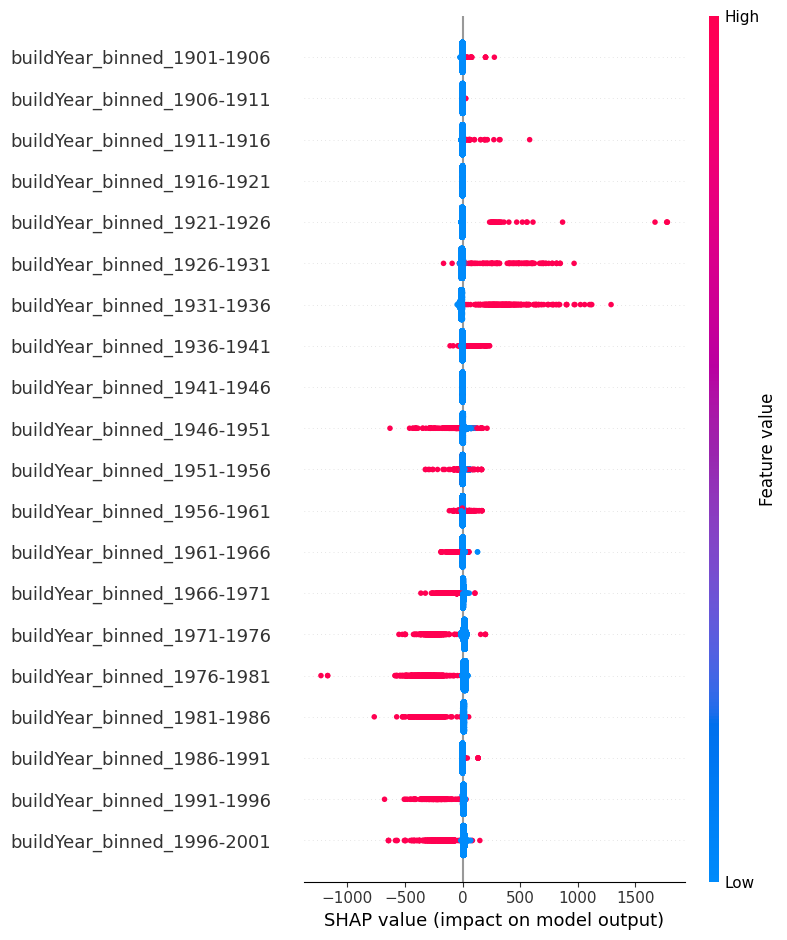

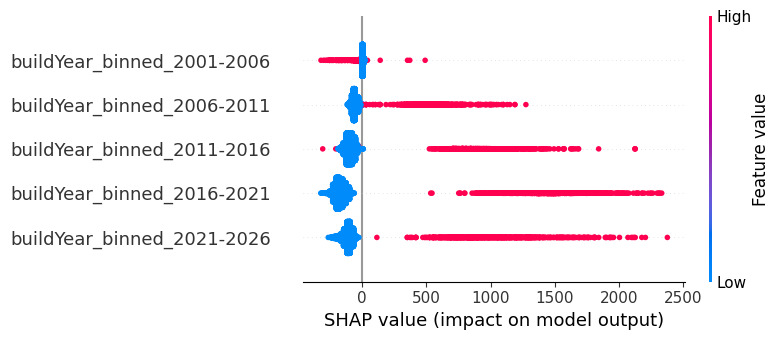

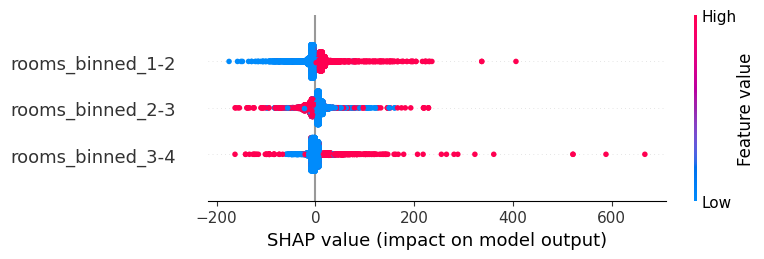

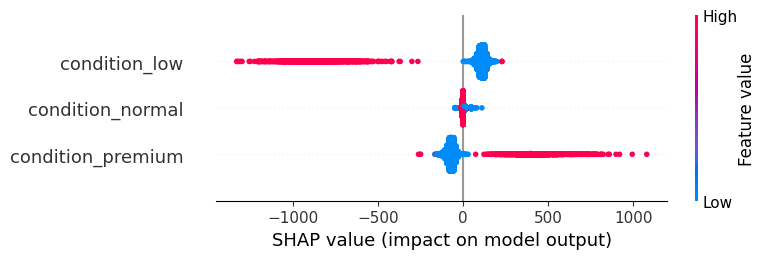

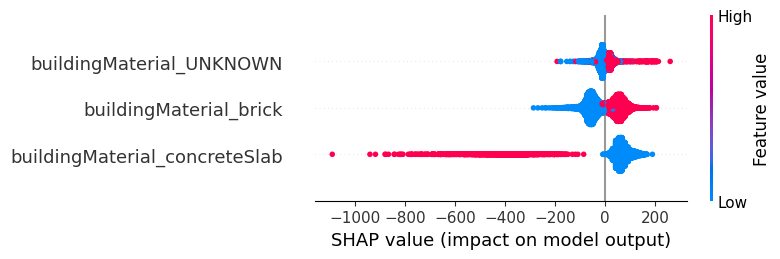

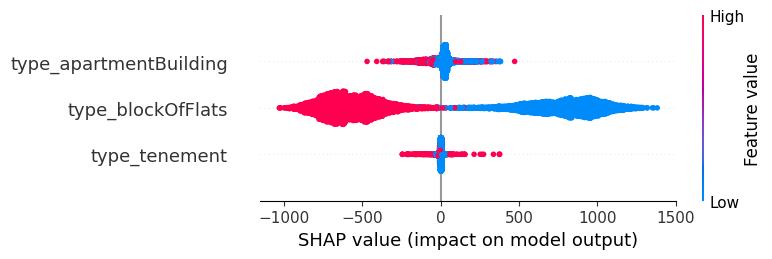

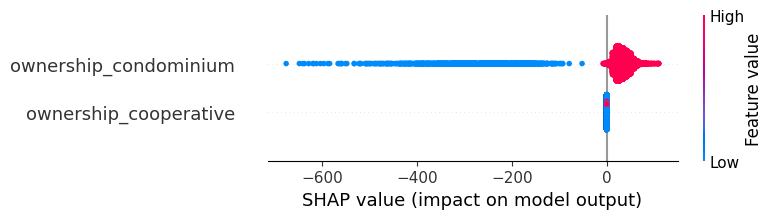

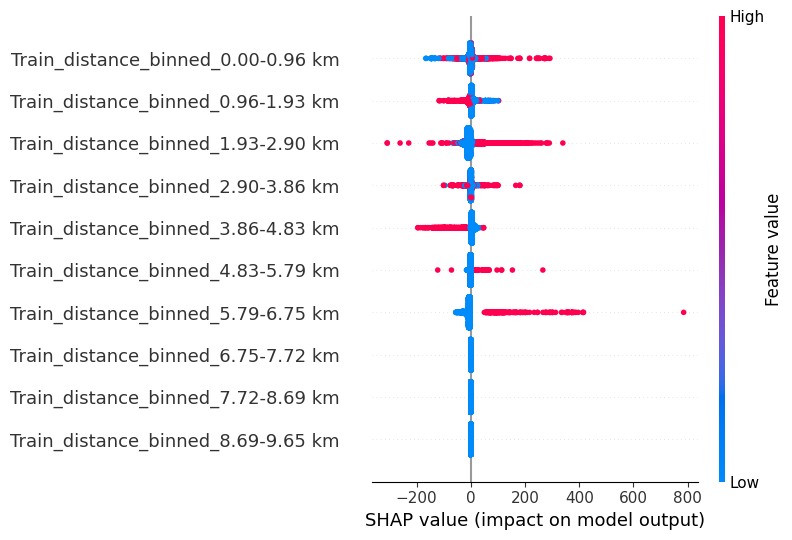

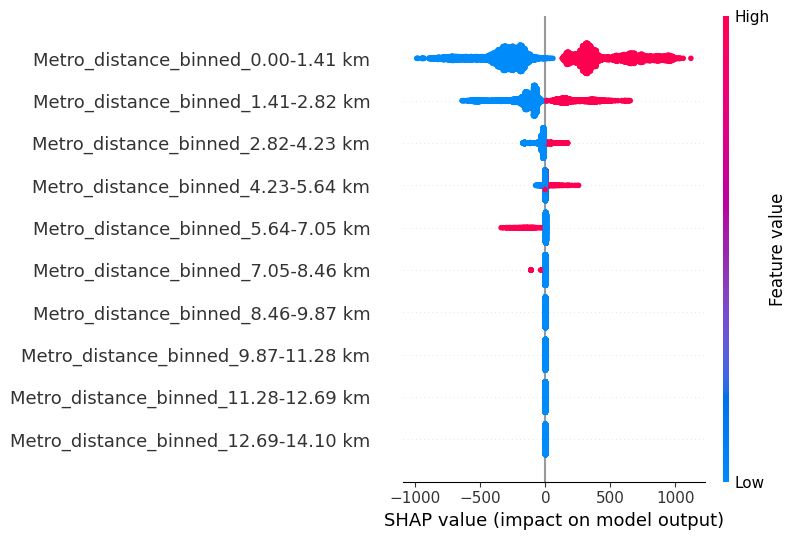

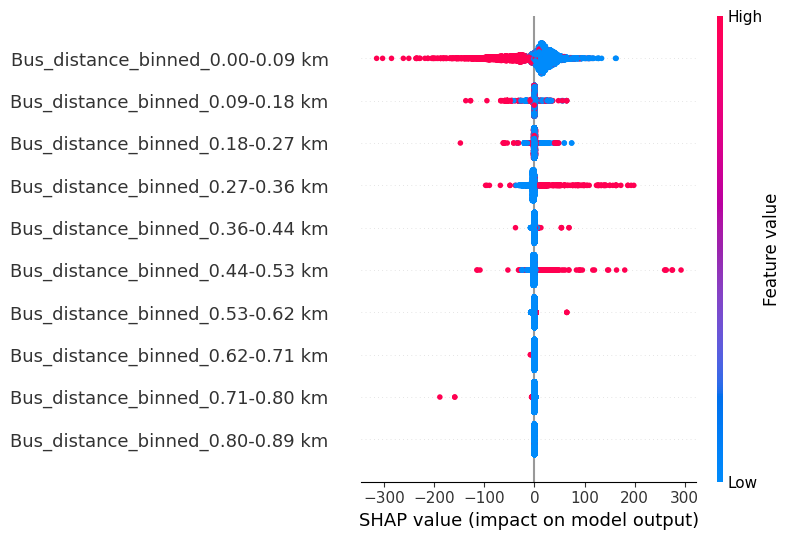

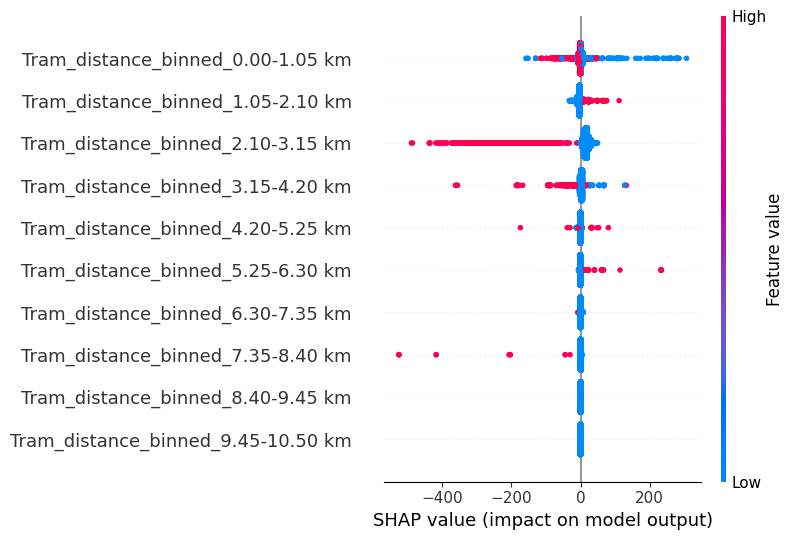

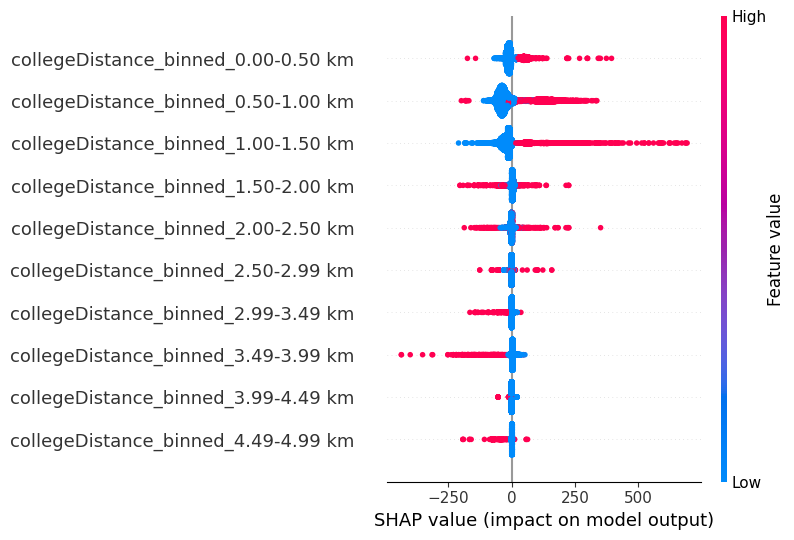

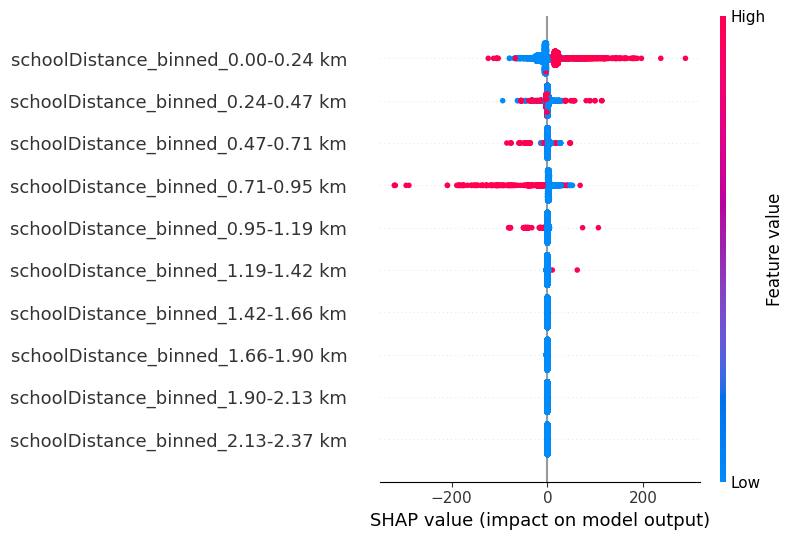

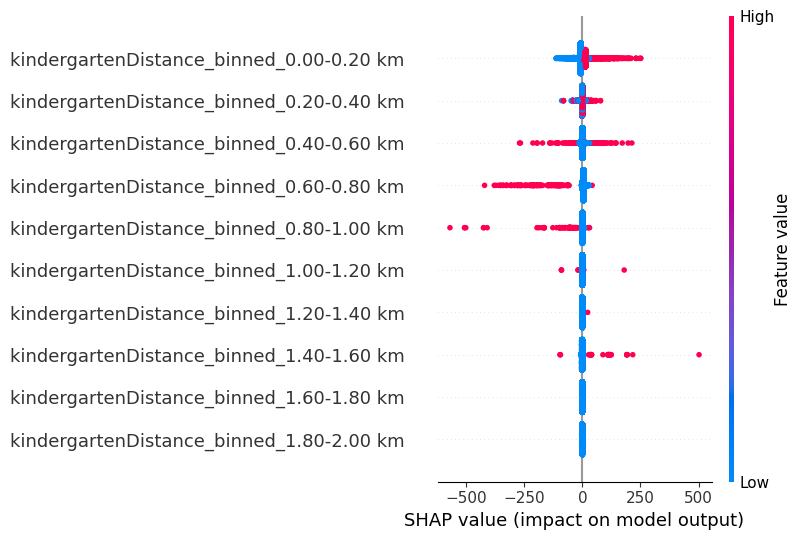

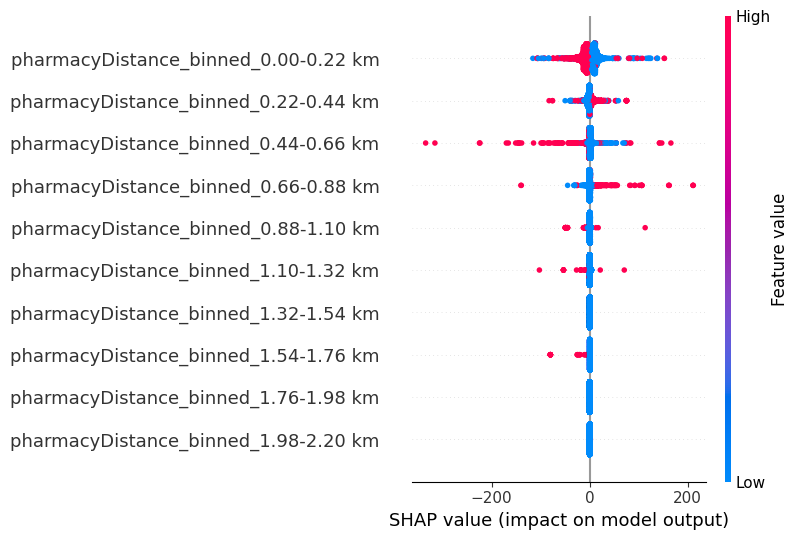

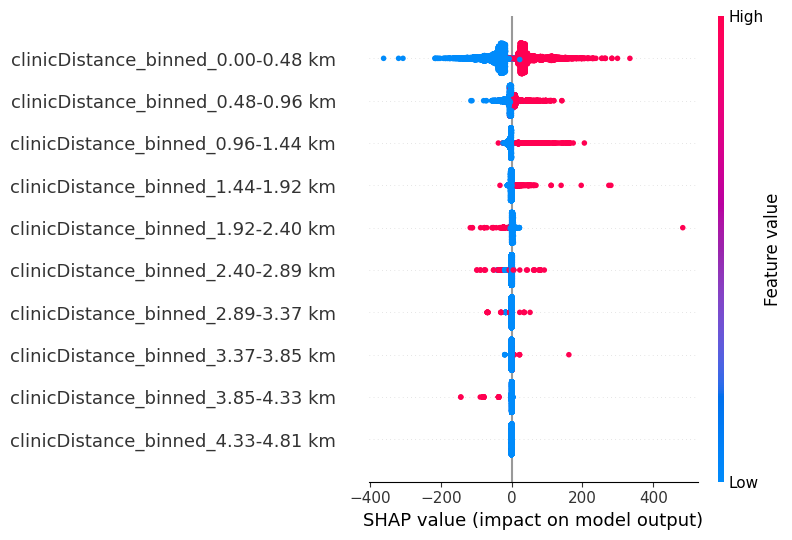

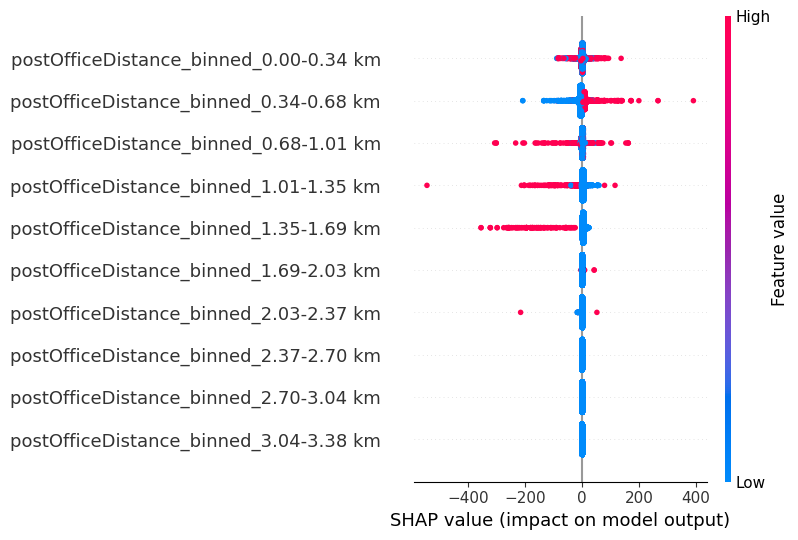

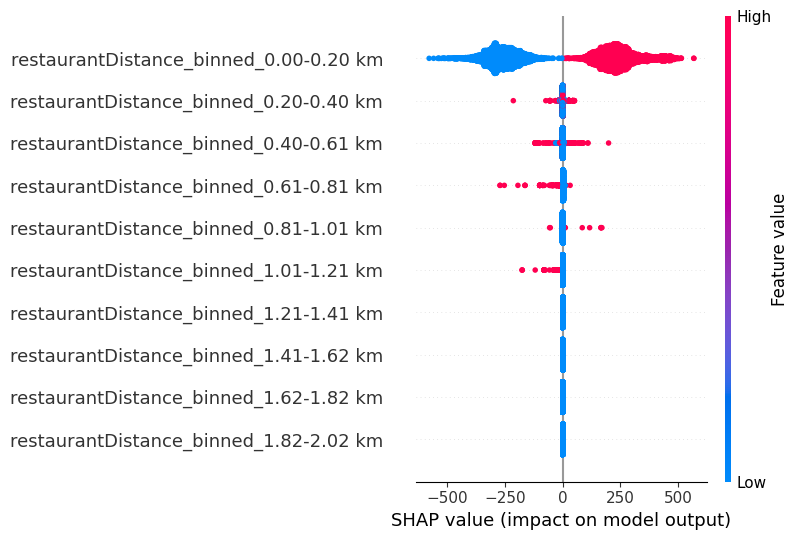

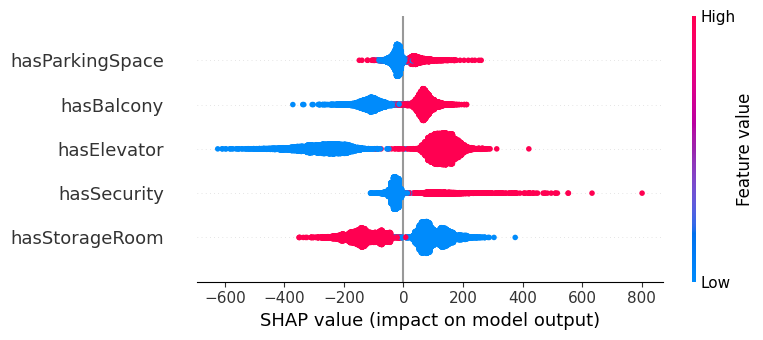

In [20]:
keywords = ['square', 'Year_binned_18','Year_binned_19','Year_binned_20','rooms', 'condition', 'Material', 'type','ownership', 'Train', 'Metro', 'Bus', 'Tram', 'llege', 'ool', 'garten', 'armacy', 'linic','ffice','estaurant','has']

for keyword in keywords:
    selected_features = find_columns_by_keyword(X, keyword)

    sorted_features = sort_by_numeric_range(selected_features)

    shap_values_array = shap_values.values

    shap_values_filtered = shap_values_array[:, [X_test.columns.get_loc(col) for col in sorted_features]]

    shap.summary_plot(shap_values_filtered, X_test[sorted_features], sort=False)




**How to Read SHAP Value Plot:**
Each label on the y-axis represents a feature, and the corresponding dots represent individual data points (records) from the dataset. The x-axis shows the impact of the feature on price (in PLN).



*   **RED dots** represent cases where the feature has a high value (for example, being close to a metro station)
*   **BLUE dots** represent cases where the feature has a low value (for example, being far from a metro station).


Each dot’s position on the x-axis shows how much that particular feature (in a specific data point) increases or decreases the predicted price. Dots to the right mean the feature increases the price, while dots to the left mean the feature decreases the price.

Example: Reading the Metro Proximity Impact Plot

Label 1: (0-1.41km)
Red dots are mainly on the right side of the plot. This indicates that apartments located 0-1.41 km from the metro tend to increase in price. The red dots show records where this feature occurs (i.e., apartments close to the metro), and their position shows the strength of the price increase.
Blue dots are on the left side, meaning that apartments further than 1.41 km from the metro generally experience a decrease in price. This shows how much not being close to the metro decreases the predicted price.

Label 2: (1.41-2.82km)
The pattern here is similar to the first label, but the dots (both red and blue) are closer to the center (0), indicating that the impact of being 1.41-2.82 km from the metro is smaller than being within the 0-1.41 km range.

Label 3: (2.82-4.23km)
Here, we see that the red dots have shifted to the left, meaning that apartments located 2.82-4.23 km from the metro tend to decrease in price. This suggests that being at this distance from the metro has a negative impact on the predicted price.

Labels 4 & 5: (4.23-7.05km)
The red dots are even further to the left, indicating that the negative impact on price increases for apartments located 4.23-7.05 km from the metro. Additionally, there are fewer dots, which means fewer apartments in the dataset are impacted by this feature in this range.

Labels 6 and beyond: (7.05-14.10km)
There are no red dots visible in these ranges, suggesting that apartments beyond 7 km from the metro do not experience any significant impact on price related to this feature. In other words, the distance from the metro is no longer relevant in affecting price predictions.





# **4. Summary**


**Key Insights:**

The results appear reliable and align with many of our initial assumptions.

**Center Distance**

*   Properties located closer to the city center tend to be more valuable, typically have fewer rooms, and are often situated on higher floors in high-rise buildings.
*   Despite their age, tenement buildings are still highly valuable due to their central location.



**Condition**


*   Modern apartment buildings constructed from brick are generally worth more.
*   Soviet-era concrete block flats tend to be less valuable.
*   Despite their age and often deteriorating condition, tenement buildings still hold significant value due to their location near the city center.


These are fairly broad assumptions that apply when considering the entire city—insights that many of us could infer without specialized expertise. However, thanks to our analysis, we now have more precise measures of each factor's impact.

**A surprising finding** is that distances to many locations are less positively correlated with price than expected. Proximity to metro stations and colleges/universities shows a meaningful impact, but other locations, such as bus or tram stops, seem to have a less substantial effect on property prices.

While it’s still evident that being near certain locations can increase property values, the relationship is much more inconsistent and fluctuates across different features. This is particularly true for features where the maximum proximity is less than 3 kilometers (bus,tram)—relatively short distances. This could suggest that external factors, which our dataset didn’t capture, might be influencing prices on a more localized, micro scale. It's important to keep in mind that we often don’t have access to all the data we would ideally need.

Refer to ths values as a refer point